
<h1> DS200A Computer Vision Assignment</h1>

<h2>  Part Three: Classifier training and performance assessment. </h2>	

In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split as sksplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt

In [2]:
def train_test_split(df):
    return sksplit(df, test_size=0.2, random_state=42)
#Split the data into a training set, and test set 
def accuracy(pred, actual):
    return np.sum(np.equal(pred, actual))/len(pred)
# Calculate the accuracy percentage of the predicted values

In [3]:
data = pd.read_pickle('transformed_data.pkl')
X, y=data.iloc[:, :-1], data.iloc[:, -1]
train, val = train_test_split(data)
X_train, Y_train = train.iloc[:, :-1], train.iloc[:, -1]
X_val, Y_val = val.iloc[:, :-1], val.iloc[:, -1]

<h3>  Train models using all of the following methods below. Be sure to drop the actual image column, and the encoding</h3>	Take note of the differences in accuracy, and methods.


## Logistic Regression

In [4]:
from sklearn.linear_model import LogisticRegression

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
log_model = LogisticRegression(multi_class='ovr', penalty='l1', C=1.0).fit(X_train, Y_train)
training_accuracy = accuracy(log_model.predict(X_train), Y_train)
val_accuracy = accuracy(log_model.predict(X_val), Y_val)
print(training_accuracy, val_accuracy)

0.41083333333333333 0.34551495016611294


In [7]:
X, y=data.iloc[:, :-1], data.iloc[:, -1]
log_model = LogisticRegression(multi_class='ovr', penalty='l1', C=1)
selector = RFECV(log_model, step=1, cv=5).fit(X, y)
rank=selector.ranking_

In [9]:
pens=np.linspace(0.1,5.1,20)
X, y=data.iloc[:, :-1], data.iloc[:, -1]
fets=range(1, max(rank)+1)
val_acc=[[0 for i in range(0, len(pens))] for j in range(0, len(fets))]

for i in range(0,len(fets)):
    n=fets[i]
    X_r=X[X.columns[rank<=n]]
    for j in range(0,len(pens)):
        log_model = LogisticRegression(multi_class='ovr', penalty='l1', C=pens[j])

        val_acc[i][j] = np.mean(cross_val_score(log_model, X_r, y, cv=5))

In [10]:
val_mat=np.matrix(val_acc)
a,b=np.unravel_index(val_mat.argmax(), val_mat.shape)
val_mat[a,b]

0.3743241836345045

In [11]:
n_opt=fets[a]
log_pen=pens[b]

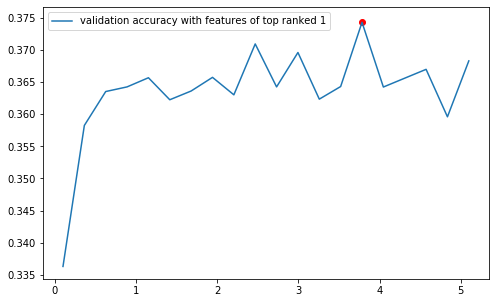

In [12]:
plt.figure(figsize=(8,5))
for i in range(0,len(fets)):
    n=fets[i]
    plt.plot(pens, val_acc[i], label='validation accuracy with features of top ranked '+str(n))
plt.scatter(pens[b], val_mat[a,b], color='r')
plt.legend();

In [13]:
columns=X.columns[rank<=n_opt]
X_train_log=X_train[columns]
X_val_log=X_val[columns]

log_model = LogisticRegression(multi_class='ovr', penalty='l1', C=log_pen).fit(X_train_log, Y_train)

training_accuracy = accuracy(log_model.predict(X_train_log), Y_train)
val_accuracy = accuracy(log_model.predict(X_val_log), Y_val)
print(training_accuracy, val_accuracy)

0.415 0.3488372093023256


Based on the result of EDA, next we will train logistic classifier on two types of samples, one has image size lower than 300000, and the other has image size larger or equal to 300000, and see if it can provide us a better result.

In [20]:
log_model_small = LogisticRegression(multi_class='ovr', penalty='l1', C=log_pen)
log_model_large = LogisticRegression(multi_class='ovr', penalty='l1', C=log_pen)
errors = []

X_train_small=X_train_log[X_train_log['size']<300000]
Y_train_small=Y_train[X_train_log['size']<300000]
X_val_small=X_val_log[X_val_log['size']<300000]
Y_val_small=Y_val[X_val_log['size']<300000]

X_train_large=X_train_log[X_train_log['size']>300000]
Y_train_large=Y_train[X_train_log['size']>300000]
X_val_large=X_val_log[X_val_log['size']>300000]
Y_val_large=Y_val[X_val_log['size']>300000]


training_accuracy_small = accuracy(log_model_small.fit(X_train_small, Y_train_small).predict(X_train_small), Y_train_small)
val_accuracy_small = accuracy(log_model_small.predict(X_val_small), Y_val_small)
print(training_accuracy_small, val_accuracy_small)

training_accuracy_large = accuracy(log_model_large.fit(X_train_large, Y_train_large).predict(X_train_large), Y_train_large)
val_accuracy_large = accuracy(log_model_large.predict(X_val_large), Y_val_large)
print(training_accuracy_large, val_accuracy_large)

print("average validation error:")
print((val_accuracy_small*len(X_train_small)+val_accuracy_large*len(X_train_large))/len(X_train_log))

0.49770992366412214 0.4117647058823529
0.3651376146788991 0.3310810810810811
average validation error:
0.3751208929517753


## K-nearest Neighbors

In [23]:
from sklearn.neighbors import KNeighborsClassifier

In [24]:
n_neighbors = 15
knn_model = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, Y_train)
training_accuracy = accuracy(knn_model.predict(X_train), Y_train)
print(training_accuracy)

0.2966666666666667


In [22]:
val_accuracy = accuracy(knn_model.predict(X_val), Y_val)
print(val_accuracy)

0.16611295681063123


## Classification Tree

In [194]:
from sklearn.tree import DecisionTreeClassifier
dtree_model = DecisionTreeClassifier(max_depth=None).fit(X_train, Y_train)
training_accuracy = accuracy(dtree_model.predict(X_train), Y_train)
print(training_accuracy)

1.0


In [195]:
val_accuracy = accuracy(dtree_model.predict(X_val), Y_val)
print(val_accuracy)

0.26245847176079734


## Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
forest_model = RandomForestClassifier(n_estimators=100, 
                                    bootstrap = True, 
                                    max_features = 'sqrt', 
                                    max_depth=None)
selector = RFECV(forest_model, step=1, cv=5).fit(X_r, y)
rank=selector.ranking_

In [232]:
val_acc=[]
deps=range(1,25)
X, y=data.iloc[:, :-1], data.iloc[:, -1]
fets=range(1, max(rank)+1)
val_acc=[[0 for i in range(0, len(deps))] for j in range(0, len(fets))]

for i in range(0,len(fets)):
    n=fets[i]
    X_r=X[X.columns[rank<=n]]
    for j in range(0,len(deps)):
        forest_model = RandomForestClassifier(n_estimators=100, 
                                                      bootstrap = True, 
                                                      max_features = 'sqrt', 
                                                      max_depth=deps[j])

        val_acc[i][j] = np.mean(cross_val_score(forest_model, X_r, y, cv=5))

In [245]:
val_mat = np.matrix(val_mat)
a,b=np.unravel_index(val_mat.argmax(), val_mat.shape)
val_mat[a,b]

0.3724163334015662

In [257]:
n_opt=fets[a]
rf_dep=deps[b]

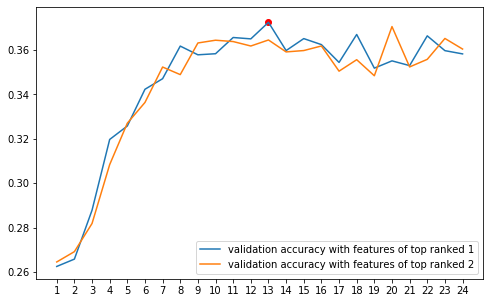

In [254]:
plt.figure(figsize=(8,5))
#plt.plot(deps, train_acc, label='train accuracy')
for i in range(0,len(fets)):
    n=fets[i]
    plt.plot(deps, val_acc[i], label='validation accuracy with features of top ranked '+str(n))
plt.scatter(deps[b], val_mat[a,b], color='r')
plt.xticks(deps)
plt.legend();

In [260]:
columns=X.columns[rank<=n_opt]
X_train_rf=X_train[columns]
X_val_rf=X_val[columns]

forest_model = RandomForestClassifier(n_estimators=100, 
                                      bootstrap = True, 
                                      max_features = 'sqrt', 
                                      max_depth=rf_dep).fit(X_train_rf, Y_train)
training_accuracy = accuracy(forest_model.predict(X_train_rf), Y_train)
val_accuracy = accuracy(forest_model.predict(X_val_rf), Y_val)
print(training_accuracy, val_accuracy)

0.9883333333333333 0.3588039867109635


## Support Vector Machine

In [ ]:
from sklearn.svm import SVC
svc_model = SVC(C=1.0, tol=1e-3, kernel='linear').fit(X_train, Y_train)
training_accuracy = accuracy(svc_model.predict(X_train), Y_train)
print(training_accuracy)

In [48]:
val_accuracy = accuracy(svc_model.predict(X_val), Y_val)
print(val_accuracy)

0.11295681063122924
